In [65]:
# Author: Uzodimma E. Igodo 
# Date: 2023-07-16
# Description: This code implements an artificial neural network for medical text classification 

#import required tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


**LOAD DATA, PERFORM EXPLORATORY DATA ANALYSIS, PREPROCESS AND CLEAN THE DATA**

In [45]:
# load csv file from directory 
# display three random rows

df = pd.read_csv(r'/kaggle/input/ca-independent-medical-review/Independent_Medical_Review__IMR__Determinations__Trend.csv')
df.sample(n = 3)

,Reference ID,Report Year,Diagnosis Category,Diagnosis Sub Category,Treatment Category,Treatment Sub Category,Determination,Type,Age Range,Patient Gender,Findings
7205,MN12-13692,2012,Foot,Other,Rehabilitation Services - Outpatient,Other,Upheld Decision of Health Plan,Medical Necessity,51-64,Male,A 63-year-old male enrollee has requested cove...
13287,EI07-7460,2007,Cardiac/Circulatory,Varicose Veins,Cardio Vascular,Other,Upheld Decision of Health Plan,Experimental/Investigational,41-50,Female,A 49-year-old female enrollee has requested sc...
17063,MN04-3671,2004,Central Nervous System/ Neuromuscular,Multiple Sclerosis,Durable Medical Equipment,Wheelchair,Upheld Decision of Health Plan,Medical Necessity,51-64,Female,The patient is a 55-year-old female with multi...


In [46]:
# select the relevant feature('Findings') and target('Determination') to create the main dataframe
# display three random examples

main_df = df[['Findings', 'Determination']]
main_df.sample(3)

,Findings,Determination
10178,A 29-year-old female enrollee has requested lu...,Upheld Decision of Health Plan
5971,The parent of a five-year-old female enrollee ...,Overturned Decision of Health Plan
13043,The parent of a five-month-old female enrollee...,Overturned Decision of Health Plan


In [47]:
# get number of examples and number of features

print(f'Number of examples before cleaning = {main_df.shape[0]}')
print(f'Number of examples = {main_df.shape[1]}')

Number of examples before cleaning = 19245
Number of examples = 2


In [48]:
# confirm that feature and label are text data ('object')

data_types = main_df.dtypes
data_types

Findings         object
Determination    object
dtype: object

In [49]:
# Transform labels from nominal categories to ordinal categories

mask = (main_df.Determination == 'Overturned Decision of Health Plan') # create mask
new_target = mask.astype('int') # change mask to integers
main_df = main_df.assign(Determination = new_target) 

In [50]:
# check for missing values or entries

num_missing = main_df.isna().sum()
num_missing

Findings         20
Determination     0
dtype: int64

In [51]:
# since missing values are from the feature vector ('Findings'), remove all missing values

main_df = main_df.dropna(axis = 0)
main_df.isna().sum() # confirm that there are no missing entries

Findings         0
Determination    0
dtype: int64

In [52]:
# show numbers of data points and features

print(f'Number of examples = {main_df.shape[0]}')
print(f'Number of examples = {main_df.shape[1]}')

Number of examples = 19225
Number of examples = 2


In [53]:
# display final dataset

main_df.head(2)

,Findings,Determination
0,Nature of Statutory Criteria/Case Summary: An ...,1
1,Nature of Statutory Criteria/Case Summary: An...,0


**DEFINE UTILITY FUNCTIONS**

In [62]:
# plot_training_log - to plot train loss vs val loss & train accuracy vs val accuracy
# get predictions - to make predictions 
# scheduler : to dynamically set learning training rate throughout the training phase

def plot_training_log(history):
    history = pd.DataFrame(data = history.history, index = history.epoch)
    fig, ax = plt.subplots(2,1, sharex = True, figsize = (5,10))
    ax[0].plot(history.index, history.loss, label = 'Train')
    ax[0].plot(history.index, history.val_loss, label = 'Validation')
    ax[0].set_ylim(0.0,0.5)
    ax[0].set_title('Train_loss vs Val_loss')
    ax[0].legend()
    ax[0].set_ylabel('Loss')
    ax[1].plot(history.index, history.accuracy, label = 'Train')
    ax[1].plot(history.index, history.val_accuracy, label = 'Validation')
    ax[1].set_ylim(0.5, 1.0)
    ax[1].set_title('Train_Accuracy vs Val_Accuracy')
    ax[1].legend()
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epochs')
    plt.show()

def get_predictions(input, label):
    logit = model.predict(input) 
    pred = np.squeeze((logit >= 0.0).astype('int'))
    return pred, label

def scheduler(epoch, lr): 
    if epoch < 10: 
        return 0.001 
    else: 
        return 0.0001 


**BUILD MODEL TRAINING PIPELINE**

In [55]:
# Create a tf.data.Dataset pipeline 

Input = main_df['Findings']
output = main_df['Determination']
data_set = tf.data.Dataset.from_tensor_slices((Input,output))


In [56]:
# use feature vector to create token vocabulary 

vocab_size = 1000
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens = vocab_size)
data_input = data_set.map(lambda x,y: x)
text_vectorizer.adapt(data_input)

In [57]:
# sanity check

original_text = main_df['Findings'][0][:70]
vocab = np.array(text_vectorizer.get_vocabulary())
text_vectors = text_vectorizer(original_text).numpy()
transcript = ' '.join(vocab[text_vectors])
print(f'Original text: {original_text}')
print('\n')
print(f'tokens: {text_vectors}')
print('\n')
print(f'Transcript: {transcript}')

Original text: Nature of Statutory Criteria/Case Summary: An enrollee has requested H


tokens: [132   3 181 182 164  27  34  12  17   1]


Transcript: nature of statutory criteriacase summary an enrollee has requested [UNK]


In [58]:
# batch, shuffle and cache the dataset to improve model robustness

data_set = data_set.batch(64).shuffle(buffer_size = 1000).cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [59]:
# split dataset into train, validation and test sets
# ~80% - Train set, ~19.99% - Validation set, ~0.01% - Test set

train_size = 0.8
num_batches = data_set.cardinality().numpy()
num_train = int(num_batches * train_size)
num_val = num_batches - num_train - 1
num_test = 1

train_set = data_set.take(num_train)
train_set_ = data_set.skip(num_train)
val_set = train_set_.take(num_val)
test_set = train_set_.skip(num_val)

# sanity check
print(f'Number of train batches {train_set.cardinality().numpy()}, Number of val batches {val_set.cardinality().numpy()}, Number of test batches {test_set.cardinality().numpy()}')

Number of train batches 240, Number of val batches 60, Number of test batches 1


In [60]:
# define model architecture
# set a learning rate scheduler callback
#compile model, use binary crossentropy and set 'from_logits' to True
# show model performance after training
# train model for 15 epochs

model = tf.keras.Sequential([text_vectorizer, tf.keras.layers.Embedding(vocab_size, 64, mask_zero = True), 
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), 
                             tf.keras.layers.Dense(8, activation = 'relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1)
                            ])

RoP = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.BinaryCrossentropy(from_logits = True), metrics = ['accuracy']) 

print(f'Test accuracy before model training {model.evaluate(test_set)[1]}')

history = model.fit(train_set, epochs=15, validation_data = val_set, callbacks = [RoP])

1/1 [==============================] - 7s 7s/step - loss: 0.6934 - accuracy: 0.5625
Test accuracy before model training 0.5625
Epoch 1/15
240/240 [==============================] - 52s 180ms/step - loss: 0.4909 - accuracy: 0.7119 - val_loss: 0.2800 - val_accuracy: 0.8984 - lr: 0.0010
Epoch 2/15
240/240 [==============================] - 13s 54ms/step - loss: 0.3142 - accuracy: 0.8307 - val_loss: 0.2183 - val_accuracy: 0.9174 - lr: 0.0010
Epoch 3/15
240/240 [==============================] - 13s 56ms/step - loss: 0.2400 - accuracy: 0.8851 - val_loss: 0.2215 - val_accuracy: 0.9102 - lr: 0.0010
Epoch 4/15
240/240 [==============================] - 13s 54ms/step - loss: 0.2280 - accuracy: 0.8886 - val_loss: 0.1995 - val_accuracy: 0.9214 - lr: 0.0010
Epoch 5/15
240/240 [==============================] - 13s 53ms/step - loss: 0.1897 - accuracy: 0.9001 - val_loss: 0.1928 - val_accuracy: 0.9221 - lr: 0.0010
Epoch 6/15
240/240 [==============================] - 13s 53ms/step - loss: 0.1838 - ac

**MODEL EVALUATION**

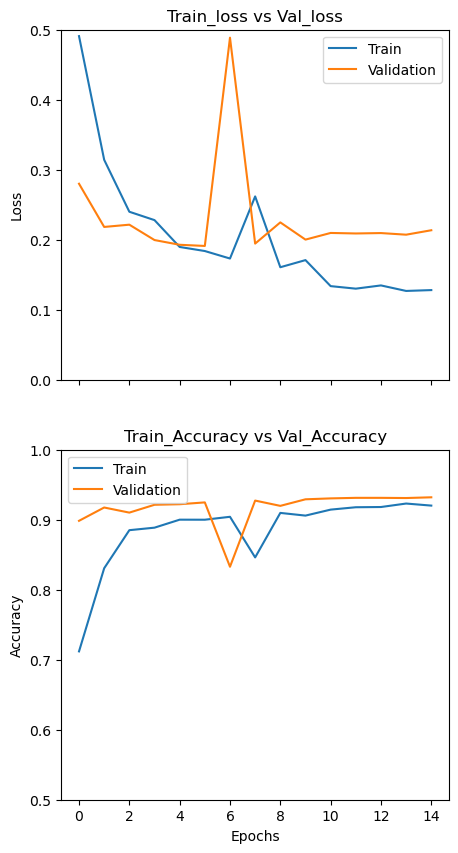

In [66]:
plot_training_log(history)

In [67]:
# show model performance after training

print(f'Test accuracy after model training {model.evaluate(test_set)[1]}')

1/1 [==============================] - 0s 50ms/step - loss: 0.0760 - accuracy: 0.9844
Test accuracy after model training 0.984375


In [68]:
# compare true label of a randomly selected text from the dataset to the predcited label

random_idx = np.random.choice(main_df.shape[0])
sample_input = main_df[['Findings']].values[random_idx]
sample_output = main_df['Determination'].values[random_idx]

v, n = get_predictions(sample_input, sample_output)
print(f'Predicted output is {v} and True label is {n}')

1/1 [==============================] - 2s 2s/step
Predicted output is 1 and True label is 1
